## Case Study

New alternator on an old engine.

The tachometer display reflects the ratio of drive wheels on a serpentine belt. There's often a peculiar-looking ratio of engine wheel size to tach wheel size, for example, 2.3:1 or 4.65:1. When the engine is rotating at 1000 RPM, the alternator may be spinning at 2300 RPM.

The new alternator has a smaller drive wheel. This means the tachometer display is now wrong.

Preliminary measurements made it look like the new wheel is $\tfrac{5}{7}$ the original wheel size. In principle it means scaling tachomter readings by $\tfrac{5}{7} = 0.7142$.

Later, with an optical device in the engine room, detailed samples were gathered. Recorded in a spreadsheet, and saved as a CSV file, `engine.csv`.

In [1]:
from csv import DictReader
from pathlib import Path

In [2]:
repo = Path.cwd().parent
source_path = repo / "data" / "engine.csv"
with source_path.open() as source_file:
    reader = DictReader(source_file)
    text_tach_readings = list(reader)
text_tach_readings

[{'Sample': '1', 'Tach': '1000', 'Engine': '883'},
 {'Sample': '2', 'Tach': '1500', 'Engine': '1242'},
 {'Sample': '3', 'Tach': '1500', 'Engine': '1217'},
 {'Sample': '4', 'Tach': '1600', 'Engine': '1306'},
 {'Sample': '5', 'Tach': '1750', 'Engine': '1534'},
 {'Sample': '6', 'Tach': '2000', 'Engine': '1805'},
 {'Sample': '7', 'Tach': '2000', 'Engine': '1720'}]

So far, so good. We have the data.

It's all text, however.

Since we need to convert it, we should convert it to something we can work with.

A named tuple.  This is an extension to the tuple class, but it has names for each item. We'll start with the `typing.NamedTuple` definition as a base class, and extend it.

In [3]:
from typing import NamedTuple

class Sample(NamedTuple):
    sample: int
    tach: float
    engine: float

We can build these objects from the input CSV file.

In [4]:
def make_sample(text_row: dict[str, str]) -> Sample:
    return Sample(
        sample=int(text_row['Sample']),
        tach=float(text_row['Tach']),
        engine=float(text_row['Engine'])
    )

In [5]:
repo = Path.cwd().parent
source_path = repo / "data" / "engine.csv"
with source_path.open() as source_file:
    reader = DictReader(source_file)
    sample_iter = (
        make_sample(text_row) for text_row in reader
    )
    tach_readings = list(sample_iter)

In [6]:
tach_readings

[Sample(sample=1, tach=1000.0, engine=883.0),
 Sample(sample=2, tach=1500.0, engine=1242.0),
 Sample(sample=3, tach=1500.0, engine=1217.0),
 Sample(sample=4, tach=1600.0, engine=1306.0),
 Sample(sample=5, tach=1750.0, engine=1534.0),
 Sample(sample=6, tach=2000.0, engine=1805.0),
 Sample(sample=7, tach=2000.0, engine=1720.0)]

Let's work through this carefully.

We create a `DictReader`. This is an iterable of `dict[str, str]` -- each dictionary is a row from the CSV file. It's assinged to the `reader` variable.

`sample_iter` is a generator expression. It consumes the rows in the `reader` object.  It performs a computation on each row, creating a `Sample()` object from the input row.

This expression's input is `Iterable[dict[str, str]]`. Output is `Iterator[float]`. We could make this into a generator function, if the conversion processing become more complex. 

The final result `tach_readings` is a list, built from the generated sequence of `Sample` objects.

## The Questions:

- How well does our initial model correlate with the actual engine?

- How well does tach reading correlate with the actual engine?

Clearly, we need to compute correlation coefficients.

## Correlation Coefficient

Here's the formula for computing the coefficient of correlation between two 
sequences of values, $x$ and $y$.

\\[ r_{xy} = \frac{\sum x y - n \bar x \bar y}{(n-1)\sigma_x\sigma_y} \\]

This means this requires the following intermediate results:

- $\sum x y$
- $\bar x$, the mean of x
- $\bar y$, the mean of y
- $\sigma_x$, the standard deviation of x
- $\sigma_y$, the standard deviation of y
- $n$, the number of samples

Here are two more formulae for $\bar x$, $\bar y$, $\sigma_x$, and $\sigma_y$:

\\[ 
\begin{align}
\bar x& = \frac{\sum x}{n}
\\
\sigma_x& = \sqrt{\frac{\frac{\sum x^2}{n-1}-\left( \frac{\sum x}{n} \right) ^ 2}{n-1}} 
\end{align}
\\] 


These require

- $\sum x$
- $\sum x^2$

In and among the various symbols like $\bar x$ and $\sigma_y$, it appears
that this computation requires a bunch of intermediate sums. 

We'll need some functions for simple sum. sum of squares, sum of products.

## Some Statistical Tools

As a test case, we'll like some data with known values for means and standard deviations.
That way we can check the ourselves. There are four small data sets called *Anscombe's Quartet* that's handy for this kind of testing.

- $\bar x = 9$
- $\bar y \approx 7.50$
- $\sigma_x \approx \sqrt {11} = 3.316$
- $\sigma_y \approx \sqrt {4.125} = 2.031$
- $r_{xy} \approx 0.816$
- Regression: $y = 3 + 0.5 x$

See https://www.kaggle.com/carlmcbrideellis/data-anscombes-quartet/version/1 for test data.

This CSV file has six columns:
- x123
- y1
- y2
- y3
- x4
- y4

To create any of the four series, use one of these combinations of columns:

1. (x123, y1)
2. (x123, y2)
3. (x123, y3)
4. (x4, y4)

We want to create a similar structure to our engine samples, so we'll have similar-looking code.

We also need to define this series to column-pair mapping.

It helps to parallel the `make_sample()` function with a `make_anscome()` function that uses the series number to decide which two columns to use.

In [7]:
class Anscombe(NamedTuple):
    x: float
    y: float
        
def make_anscombe(
        text_row: dict[str, str], 
        series: int = 1
) -> Anscombe:
    pairs = {
        1: ("x123", "y1"),
        2: ("x123", "y2"),
        3: ("x123", "y3"),
        4: ("x4", "y4"),
    }

    x_col, y_col = pairs[series]
    return Anscombe(
        float(text_row[x_col]),
        float(text_row[y_col])
    )
    
repo = Path.cwd().parent
series_source = repo / "data" / "Anscombe_quartet_data.csv"
with series_source.open() as source:
    reader = DictReader(source)
    anscome_iter = (
        make_anscombe(text_row)
        for text_row in reader
    )
    test_series = list(anscome_iter)
    
test_series

[Anscombe(x=10.0, y=8.04),
 Anscombe(x=8.0, y=6.95),
 Anscombe(x=13.0, y=7.58),
 Anscombe(x=9.0, y=8.81),
 Anscombe(x=11.0, y=8.33),
 Anscombe(x=14.0, y=9.96),
 Anscombe(x=6.0, y=7.24),
 Anscombe(x=4.0, y=4.26),
 Anscombe(x=12.0, y=10.84),
 Anscombe(x=7.0, y=4.82),
 Anscombe(x=5.0, y=5.68)]

In [8]:
from collections.abc import Iterable

In [9]:
def sum_2(data: Iterable[float]) -> float:
    return sum(v**2 for v in data)

In [10]:
def sum_prod(s_1: Iterable[float], s_2: Iterable[float]) -> float:
    pairs = zip(s_1, s_2)
    return sum(
        x*y for x, y in pairs
    )

In [11]:
def mean(data: list[float]) -> float:
    return sum(data) / len(data)

In [12]:
from math import sqrt

def stdev(data: list[float]) -> float:
    n = len(data)
    mean_2 = (sum(data) / n) ** 2
    squares = sum_2(data) / (n-1)
    return sqrt(squares - mean_2 * n / (n - 1))

In [13]:
mean([s.x for s in test_series])

9.0

In [14]:
mean([s.y for s in test_series])

7.500909090909091

In [15]:
stdev([s.x for s in test_series])

3.3166247903554

In [16]:
stdev([s.y for s in test_series])

2.031568135925813

In [17]:
from math import isclose
assert isclose(mean([s.x for s in test_series]), 9.0)
assert isclose(mean([s.y for s in test_series]), 7.5, abs_tol=1E-3)
assert isclose(stdev([s.x for s in test_series]), 3.316, abs_tol=1E-3)
assert isclose(stdev([s.y for s in test_series]), 2.031, abs_tol=1E-3)

In [18]:
def corr(s_1: list[float], s_2: list[float]) -> float:
    n = len(s_1)
    num = sum_prod(s_1, s_2) - n * mean(s_1) * mean(s_2)
    den = (n-1) * stdev(s_1) * stdev(s_2)
    return num / den

In [19]:
corr([s.x for s in test_series], [s.y for s in test_series])

0.8164205163448406

In [20]:
assert isclose(corr([s.x for s in test_series], [s.y for s in test_series]), 0.816, abs_tol=1E-3)

## Now That We Have Stats

First, tach vs. engine correlation? Are these consistent?

In [21]:
corr([s.tach for s in tach_readings], [s.engine for s in tach_readings])

0.9847275588081925

That's wonderful to see. It means the optical device and the tachometer are likely to agree.

The question now, is how far wrong is this model? What's the range of gaps between model engine RPM's and actual engine RPM's.

In [22]:
def engine_1(s: Sample):
    return s.tach * 0.7142

In [23]:
diffs_1 = [
    engine_1(s) - s.engine for s in tach_readings
]

In [24]:
min(diffs_1), max(diffs_1), mean(diffs_1)

(-376.60000000000014, -145.70000000000005, -228.6900000000001)

The predictions of the `engine_1()` model are wrong by anywhere from 146 to 376 RPM's. On average, it's wrong by 228 RPMS.  And, since all the numbers are negative, the model is consistently too low.

This is, perhaps, less than ideal.

## Visual Aids

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
x = [s.tach for s in tach_readings]
y = [s.engine for s in tach_readings]
est_1 = [engine_1(s) for s in tach_readings]

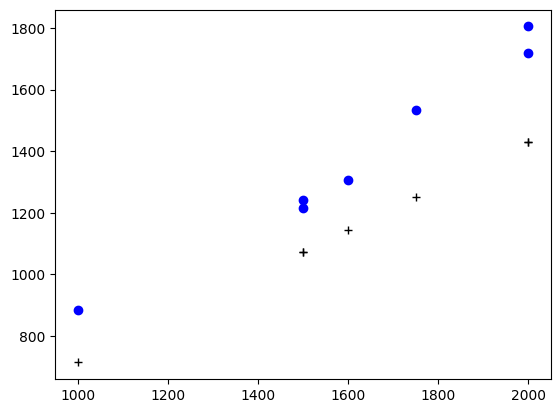

In [27]:
plt.plot(x, y, 'o', color='blue')
plt.plot(x, est_1, '+', color='black')

In [28]:
plt.savefig("corr1.png", format="png")

<Figure size 640x480 with 0 Axes>

The estimations are consistently below the actual values. And they seem to have a wrong slope.

## Linear Regression

Given the correlation value, $r_{xy}$, we can compute the linear regression $y = a + bx$ line as follows:

\\[
\begin{align}
b& = \frac{\sum {x}{y} - n  \bar x \bar y}{(n-1){\sigma_x} ^ 2} = r_{xy} \frac {\sigma_y}{\sigma_x}
\\
a& = \bar y - b \bar x
\end{align}
\\]

This doesn't seem to require any new computations.

In [29]:
def regression(s_1: list[float], s_2: list[float]) -> tuple[float, float]:
    b = corr(s_1, s_2) * stdev(s_2)/stdev(s_1)
    a = mean(s_2) - b * mean(s_1)
    return a, b

Test Case using the `test_series`.

In [30]:
regression([s.x for s in test_series], [s.y for s in test_series])

(3.0000909090909094, 0.500090909090909)

The above means $y = a + bx = 3 + 0.5x$. This was the expected answer from Anscombe's Quartet.

In [31]:
a, b = regression([s.x for s in test_series], [s.y for s in test_series])
for s in test_series:
    print(f"{s.x:5.2f} {s.y:5.2f} model={a+b*s.x:5.2f}")

10.00  8.04 model= 8.00
 8.00  6.95 model= 7.00
13.00  7.58 model= 9.50
 9.00  8.81 model= 7.50
11.00  8.33 model= 8.50
14.00  9.96 model=10.00
 6.00  7.24 model= 6.00
 4.00  4.26 model= 5.00
12.00 10.84 model= 9.00
 7.00  4.82 model= 6.50
 5.00  5.68 model= 5.50


## Regression applied to engine data

This is the crux of the problem.

In [32]:
a, b = regression(
    [s.tach for s in tach_readings], 
    [s.engine for s in tach_readings]
)

In [33]:
f"engine = {a:.1f} + {b:.2f} × tach"

'engine = -92.9 + 0.91 × tach'

In [34]:
def engine_2(s: Sample):
    return -92.9 + 0.91 * s.tach

In [35]:
diffs_2 = [
    engine_2(s) - s.engine for s in tach_readings
]

In [36]:
min(diffs_2), max(diffs_2), mean(diffs_2)

(-77.90000000000009, 57.09999999999991, -4.114285714285789)

This is much nicer. The differences are less than 80 RPM, and they vary in sign between negative and positive. The averge is less than 5 RPM.

In [37]:
est_2 = [engine_2(s) for s in tach_readings]

Text(0.5, 1.0, 'Regression Model')

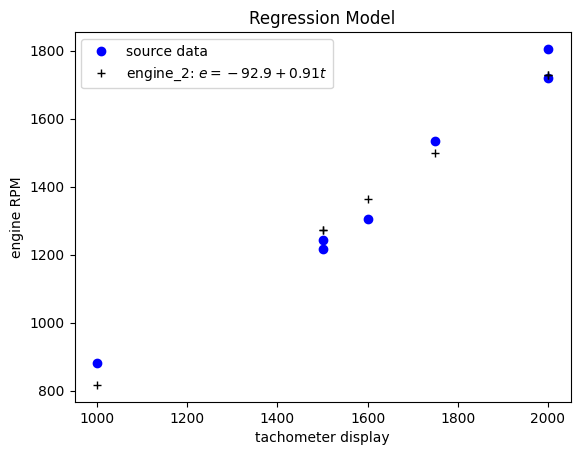

In [38]:
data, = plt.plot(x, y, 'o', color='blue', 
                 label='source data')
model, = plt.plot(x, est_2, '+', color='black', 
                  label='engine_2: $e=-92.9 + 0.91t$')
plt.legend(handles=[data, model])
plt.ylabel('engine RPM')
plt.xlabel('tachometer display')
plt.title('Regression Model')

In [ ]:
plt.savefig("corr2.png", format="png")

This shows how well the new model fits the available data points.

## Summary

We followed a typical process for working with data in a Python. We opened a Jupyter Lab notebook, and loaded the data. 

We then defined some functions in the notebook. In the long run, it's slightly better to save the functions in a module file and import the module into the notebook. When getting started with new data or a new problem domain, defining functions in the notebook keeps everything in one place.

The process of defining the functions was done by first pasting the relevant background information into markdown cell. Then defining a function that matched the definition, then testing the function to be sure it worked.

Once the preliminaries of data and processing were completed, we could move on to applying the processing to the available data.

First, we saw a good correlation between the measurements taken with the optical device and the display shown on the tachometer. This told us we were using the optical device correctly, and had not introduced some  measurement error.

Second, we saw that our initial model was consistently wrong about predicting actual engine RPM's from the tachometer display.

Third, we used linear regression to create a better model. This made consistently correct predictions of RPM given tachometer display.

The results are all in a single notebook for further review and follow-on work.